In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [ ]:
!ls -ltr
!hostname -i

total 4
drwxr-xr-x 1 root root 4096 Jun 16 18:16 sample_data
172.28.0.12


In [ ]:
!git clone https://github.com/amitkml/ERA-V1

Cloning into 'ERA-V1'...
remote: Enumerating objects: 154, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 154 (delta 41), reused 108 (delta 25), pack-reused 26
Receiving objects: 100% (154/154), 85.75 MiB | 17.14 MiB/s, done.
Resolving deltas: 100% (42/42), done.
Updating files: 100% (95/95), done.


In [ ]:
cd "/content/ERA-V1/Session8"

/content/ERA-V1/Session8


# Loading UD modules

In [ ]:
import pandas as pd
import numpy as np

import torch
import data_utils as dutils
import model_utils as mutils
import plot_utils as putils
import regularization
import model_cifar as mod_cifar
import model_cifar_gnorm as model_gcifar
import model_cifar_lnorm as model_cifar_lnorm
import matplotlib.pyplot as plt
import seaborn as sns
import models as mod

import os

# Check GPU avaiability

In [ ]:
device = dutils.get_device()

CUDA Available? True
Device is cuda:0


In [ ]:
device.type

'cuda'

In [ ]:
cuda = torch.cuda.is_available()

In [ ]:
cuda

True

# CIFAR10 Basics

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

SEED = 1
batch_size=64

# CUDA?
if device.type == 'cuda':
    torch.cuda.manual_seed(SEED)
else:
    torch.manual_seed(SEED)

# Load CIFAR10 dataset

In [ ]:
os.getcwd()

'/content/ERA-V1/Session8'

In [ ]:
path = os.getcwd()
path

'/content/ERA-V1/Session8'

In [ ]:
# load CIFAR10 dataset
train_loader, test_loader = dutils.get_dataloader(batch_size=batch_size, num_workers=4, cuda = True,path = path )

Running over Cuda !!  True


100%|██████████| 170498071/170498071 [00:11<00:00, 15467549.77it/s]


Extracting /content/ERA-V1/Session8/cifar-10-python.tar.gz to /content/ERA-V1/Session8
Files already downloaded and verified


# Data mage Visualization

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


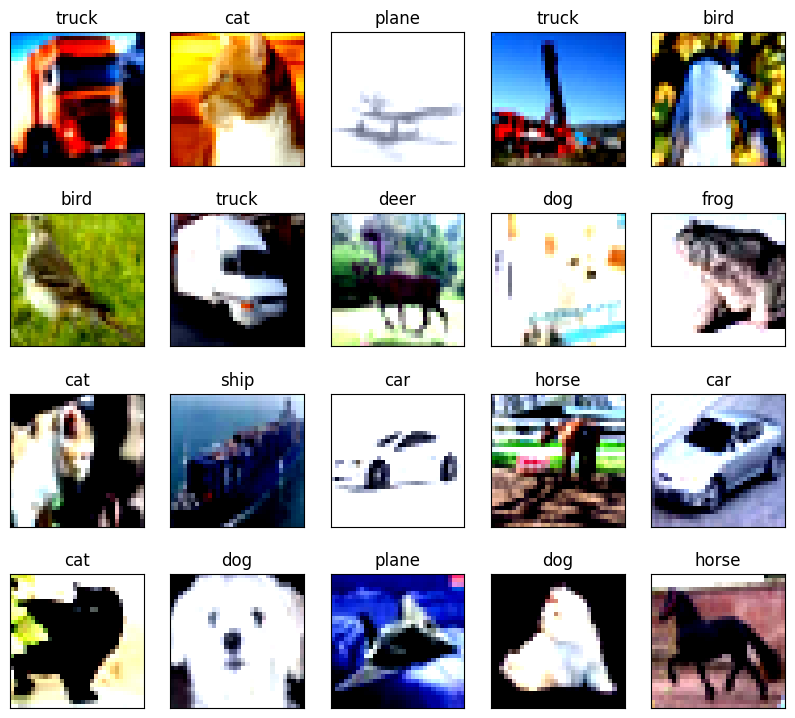

In [ ]:
#Plot 20 random images
putils.plot_dataset_images(device, classes, train_loader)

# Model with BN - From github

### Model structure

In [ ]:
# from __future__ import print_function
# import torch
# import torchvision
# import torch.nn as nn
# import torch.nn.functional as F
# from torchsummary import summary
# import torch.optim as optim
# from torchvision import datasets, transforms
# from torch.optim.lr_scheduler import StepLR

# import numpy as np
# import matplotlib.pyplot as plt

# import regularization

# class Net(nn.Module):
#     def __init__(self,dropout_value = 0):
#         super(Net, self).__init__()


#         ## CONVOLUTION BLOCK 1
#         self.convblock1 = nn.Sequential(
#             nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = (3,3), stride=1, padding=1),
# #             nn.Conv2d(in_channels=3, out_channels=33, kernel_size=(3, 3), padding=1, groups = 3, bias=False),
# #             nn.Conv2d(in_channels=33, out_channels=16, kernel_size=(1, 1), padding=1, bias=False),
#             nn.BatchNorm2d(16),
#             nn.Dropout(dropout_value),
#             nn.ReLU()
#         ) # input_size = 32 output_size = 32 receptive_field = 3

#         self.convblock2 = nn.Sequential(
# #             nn.ConvTranspose2d(in_channels = 3, out_channels = 32, kernel_size = (3,3), stride=2, padding=1),
#             nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, groups = 16, bias=False),
#             nn.Conv2d(in_channels=32, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
#             nn.BatchNorm2d(8),
#             nn.Dropout(dropout_value),
#             nn.ReLU()
#         ) # input_size = 32 output_size = 32 receptive_field = 5


#         self.pool1 = nn.MaxPool2d(2, 2) # input_size = 32 output_size = 16 receptive_field = 10


#         ## CONVOLUTION BLOCK 2
#         self.convblock3 = nn.Sequential(
#             # Dilated Convolution of 3
#             nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1,dilation = 1, bias=False),
#             nn.BatchNorm2d(16),
#             nn.Dropout(dropout_value),
#             nn.ReLU(),
#         ) # input_size = 16 output_size = 16 receptive_field = 14

#         self.convblock4 = nn.Sequential(
#             # Dilated Convolution of 3
#             nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, groups = 16, bias=False),
#             nn.Conv2d(in_channels=32, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
#             nn.BatchNorm2d(8),
#             nn.Dropout(dropout_value),
#             nn.ReLU(),
#         ) # input_size = 16 output_size = 16 receptive_field = 16

#         self.pool2 = nn.MaxPool2d(2, 2) # input_size = 16 output_size = 8   receptive_field = 32


#         ## CONVOLUTION BLOCK 3
#         self.convblock5 = nn.Sequential(
#             nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1, dilation = 2, bias=False),
#             nn.BatchNorm2d(16),
#             nn.Dropout(dropout_value),
#             nn.ReLU()
#         ) # input_size = 6   output_size = 6 receptive_field = 35

#         self.convblock6 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, dilation = 1, groups = 16, bias=False),
#             nn.Conv2d(in_channels=32, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
#             nn.BatchNorm2d(8),
#             nn.Dropout(dropout_value),
#             nn.ReLU()
#         ) # input_size = 6   output_size = 6 receptive_field = 39

#         ## CONVOLUTION BLOCK 4
#         self.convblock7 = nn.Sequential(
#             nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1, dilation = 1, bias=False),
#             nn.BatchNorm2d(16),
#             nn.Dropout(dropout_value),
#             nn.ReLU()
#         ) # input_size = 8   output_size = 8 receptive_field = 43

# #         self.convblock8 = nn.Sequential(
# #             nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), padding=0, dilation = 1, bias=False),
# #             nn.BatchNorm2d(256),
# #             nn.Dropout(dropout_value),
# #             nn.ReLU()
# #         ) # input_size = 8   output_size = 6  receptive_field = 45



#         self.gap = nn.AvgPool2d(kernel_size=(6,6))
#         self.fc1 = nn.Linear(16, 10)

#     def forward(self, x):
#         x = self.pool1(self.convblock2(self.convblock1(x)))
#         x = self.pool2(self.convblock4(self.convblock3(x)))
#         x = self.convblock6(self.convblock5(x))
#         x = self.convblock7(x)
# #         x = self.convblock8(self.convblock7(x))
#         x = self.gap(x)
#         # print(x.shape)
#         x = x.view(x.size(0),-1)
#         x = self.fc1(x)

#         return F.log_softmax(x, dim=-1)

In [ ]:
# model = mod.ResNet18()
# model = Net() ##
model = mod_cifar.model_cifar()

In [ ]:
mutils.model_summary(model, device, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
           Dropout-3           [-1, 16, 32, 32]               0
              ReLU-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]             288
            Conv2d-6            [-1, 8, 32, 32]             256
       BatchNorm2d-7            [-1, 8, 32, 32]              16
           Dropout-8            [-1, 8, 32, 32]               0
              ReLU-9            [-1, 8, 32, 32]               0
        MaxPool2d-10            [-1, 8, 16, 16]               0
           Conv2d-11           [-1, 16, 16, 16]           1,152
      BatchNorm2d-12           [-1, 16, 16, 16]              32
          Dropout-13           [-1, 16, 16, 16]               0
             ReLU-14           [-1, 16,

In [ ]:
# Create CIFAR10 network
# model = model_cifar.Net(dropout_value = 0.05)
# mutils.model_summary(model, device, input_size=(3, 32, 32))

## Build and train model

In [ ]:
test_loader

In [ ]:
# build and train the model
model_name = "Model CIFAR10"
EPOCHS = 20
model =  model.to(device) # use GPU

# using L1 and L2 regularization
train_acc, train_losses, test_acc, test_losses = mutils.build_model(model,
                                                            device,
                                                            trainloader=train_loader,
                                                            testloader=test_loader,
                                                            epochs=EPOCHS,
                                                            L1_loss_flag=True,
                                                            L2_penalty_val=0.001)

EPOCH: 0


Loss=1.563488 Batch_id=781 Accuracy=41.60: 100%|██████████| 782/782 [00:44<00:00, 17.67it/s]



Test set: Average loss: 1.423990, Accuracy: 4903/10000 (49.03%)

EPOCH: 1


Loss=1.285315 Batch_id=781 Accuracy=53.74: 100%|██████████| 782/782 [00:43<00:00, 17.79it/s]



Test set: Average loss: 1.888335, Accuracy: 3935/10000 (39.35%)

EPOCH: 2


Loss=1.206286 Batch_id=781 Accuracy=57.17: 100%|██████████| 782/782 [00:45<00:00, 17.10it/s]



Test set: Average loss: 1.441150, Accuracy: 4815/10000 (48.15%)

EPOCH: 3


Loss=1.161970 Batch_id=781 Accuracy=58.75: 100%|██████████| 782/782 [00:41<00:00, 18.76it/s]



Test set: Average loss: 1.433556, Accuracy: 5100/10000 (51.00%)

EPOCH: 4


Loss=1.141017 Batch_id=781 Accuracy=59.65: 100%|██████████| 782/782 [00:41<00:00, 19.07it/s]



Test set: Average loss: 1.573668, Accuracy: 4364/10000 (43.64%)

EPOCH: 5


Loss=1.120391 Batch_id=781 Accuracy=60.45: 100%|██████████| 782/782 [00:41<00:00, 18.91it/s]



Test set: Average loss: 1.396861, Accuracy: 5207/10000 (52.07%)

EPOCH: 6


Loss=1.119242 Batch_id=781 Accuracy=60.34: 100%|██████████| 782/782 [00:41<00:00, 18.89it/s]



Test set: Average loss: 1.691579, Accuracy: 4682/10000 (46.82%)

EPOCH: 7


Loss=1.102783 Batch_id=781 Accuracy=61.39: 100%|██████████| 782/782 [00:42<00:00, 18.53it/s]



Test set: Average loss: 1.546818, Accuracy: 4707/10000 (47.07%)

EPOCH: 8


Loss=0.914340 Batch_id=781 Accuracy=68.11: 100%|██████████| 782/782 [00:43<00:00, 18.18it/s]



Test set: Average loss: 0.871134, Accuracy: 6899/10000 (68.99%)

EPOCH: 9


Loss=0.868999 Batch_id=781 Accuracy=69.37: 100%|██████████| 782/782 [00:49<00:00, 15.94it/s]



Test set: Average loss: 0.903660, Accuracy: 6843/10000 (68.43%)

EPOCH: 10


Loss=0.852489 Batch_id=781 Accuracy=70.34: 100%|██████████| 782/782 [00:44<00:00, 17.77it/s]



Test set: Average loss: 0.886230, Accuracy: 6853/10000 (68.53%)

EPOCH: 11


Loss=0.847795 Batch_id=781 Accuracy=70.43: 100%|██████████| 782/782 [00:39<00:00, 19.67it/s]



Test set: Average loss: 0.881946, Accuracy: 6908/10000 (69.08%)

EPOCH: 12


Loss=0.838506 Batch_id=781 Accuracy=70.61: 100%|██████████| 782/782 [00:44<00:00, 17.74it/s]



Test set: Average loss: 0.880525, Accuracy: 6904/10000 (69.04%)

EPOCH: 13


Loss=0.840811 Batch_id=781 Accuracy=70.69: 100%|██████████| 782/782 [00:41<00:00, 19.04it/s]



Test set: Average loss: 0.969509, Accuracy: 6676/10000 (66.76%)

EPOCH: 14


Loss=0.836766 Batch_id=781 Accuracy=70.64: 100%|██████████| 782/782 [00:44<00:00, 17.72it/s]



Test set: Average loss: 0.888952, Accuracy: 6893/10000 (68.93%)

EPOCH: 15


Loss=0.831639 Batch_id=781 Accuracy=70.80: 100%|██████████| 782/782 [00:43<00:00, 18.00it/s]



Test set: Average loss: 0.929015, Accuracy: 6628/10000 (66.28%)

EPOCH: 16


Loss=0.770694 Batch_id=781 Accuracy=73.09: 100%|██████████| 782/782 [00:45<00:00, 17.15it/s]



Test set: Average loss: 0.793432, Accuracy: 7206/10000 (72.06%)

EPOCH: 17


Loss=0.755664 Batch_id=781 Accuracy=73.81: 100%|██████████| 782/782 [00:41<00:00, 18.71it/s]



Test set: Average loss: 0.787068, Accuracy: 7242/10000 (72.42%)

EPOCH: 18


Loss=0.750773 Batch_id=781 Accuracy=73.88: 100%|██████████| 782/782 [00:45<00:00, 17.18it/s]



Test set: Average loss: 0.793600, Accuracy: 7223/10000 (72.23%)

EPOCH: 19


Loss=0.746921 Batch_id=781 Accuracy=74.08: 100%|██████████| 782/782 [00:50<00:00, 15.61it/s]



Test set: Average loss: 0.790387, Accuracy: 7239/10000 (72.39%)



## Test Accuracy

In [ ]:
mutils.get_test_accuracy(model, device, test_loader)


Accuracy of the network on the 10000 test images: 72.39%



### Class level Accuracy

In [ ]:
mutils.class_based_accuracy(model, device, classes, test_loader)

Accuracy of plane : 87 %
Accuracy of   car : 84 %
Accuracy of  bird : 58 %
Accuracy of   cat : 47 %
Accuracy of  deer : 85 %
Accuracy of   dog : 47 %
Accuracy of  frog : 77 %
Accuracy of horse : 70 %
Accuracy of  ship : 81 %
Accuracy of truck : 85 %


## Visualization


Ploting Accuracy and Loss history: Model CIFAR10



TypeError: ignored

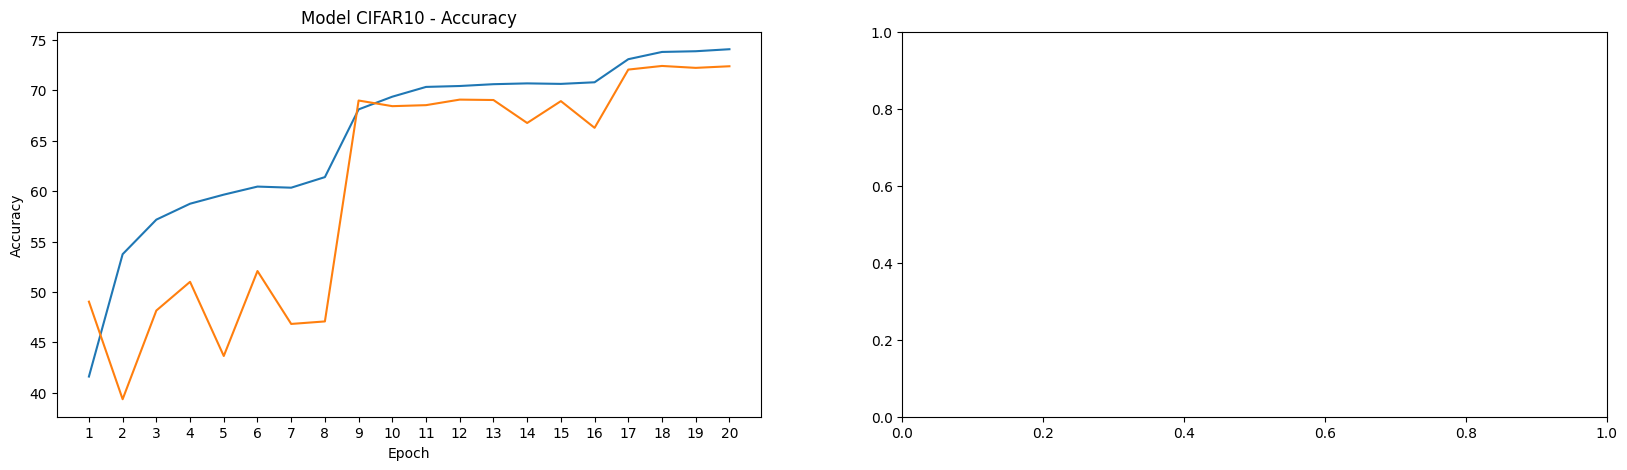

In [ ]:
print("\nPloting Accuracy and Loss history: {}\n".format(model_name))
putils.plot_model_history(model_name,
                   train_acc,test_acc,
                   train_losses,test_losses,
                   save_filename = "model_history")

## Misclassified images


Ploting misclassified images: Model CIFAR10



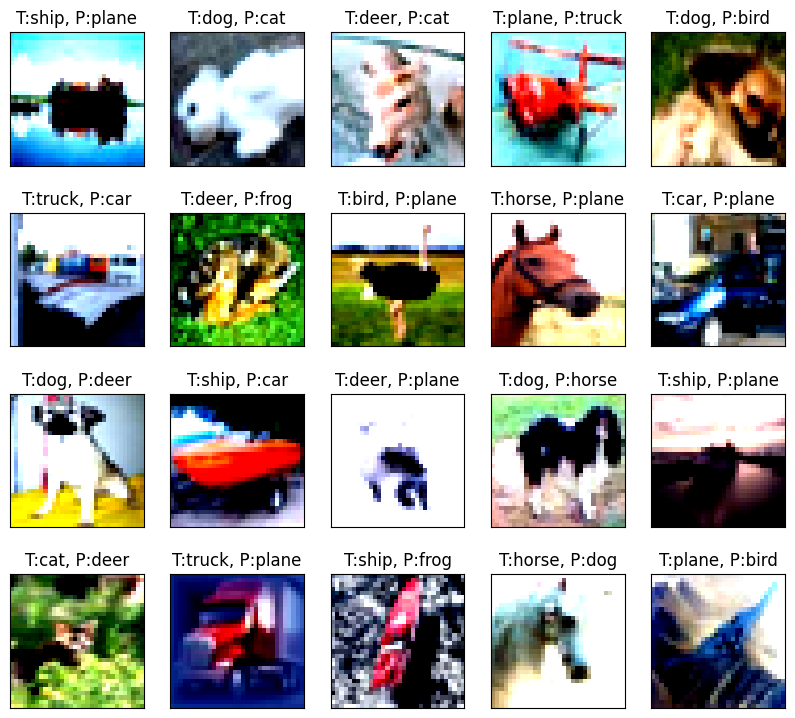

In [ ]:
print ("\nPloting misclassified images: {}\n".format(model_name))

putils.miss_classification('Test',model,
                          device,
                          classes,
                          testloader=test_loader,
                          num_of_images = 20,
                          save_filename="model_misclassified")

# Model with LN From Github

### Model structure

In [ ]:
# from __future__ import print_function
# import torch
# import torchvision
# import torch.nn as nn
# import torch.nn.functional as F
# from torchsummary import summary
# import torch.optim as optim
# from torchvision import datasets, transforms
# from torch.optim.lr_scheduler import StepLR

# import numpy as np
# import matplotlib.pyplot as plt

# import regularization
# multiplier = 2
# class LNet(nn.Module):
#     def __init__(self,dropout_value = 0):
#         super(LNet, self).__init__()


#         ## CONVOLUTION BLOCK 1
#         self.convblock1 = nn.Sequential(
#             nn.Conv2d(in_channels = 3, out_channels = 16*multiplier, kernel_size = (3,3), stride=1, padding=1),
# #             nn.Conv2d(in_channels=3, out_channels=33, kernel_size=(3, 3), padding=1, groups = 3, bias=False),
# #             nn.Conv2d(in_channels=33, out_channels=16, kernel_size=(1, 1), padding=1, bias=False),
#             # nn.BatchNorm2d(16),
#             nn.GroupNorm(1,16*multiplier),
#             nn.Dropout(dropout_value),
#             nn.ReLU()
#         ) # input_size = 32 output_size = 32 receptive_field = 3

#         self.convblock2 = nn.Sequential(
# #             nn.ConvTranspose2d(in_channels = 3, out_channels = 32, kernel_size = (3,3), stride=2, padding=1),
#             nn.Conv2d(in_channels=16*multiplier, out_channels=32*multiplier, kernel_size=(3, 3), padding=1, bias=False),
#             nn.Conv2d(in_channels=32*multiplier, out_channels=8*multiplier, kernel_size=(1, 1), padding=0, bias=False),
#             # nn.BatchNorm2d(8),
#             nn.GroupNorm(1,8*multiplier),
#             nn.Dropout(dropout_value),
#             nn.ReLU()
#         ) # input_size = 32 output_size = 32 receptive_field = 5


#         self.pool1 = nn.MaxPool2d(2, 2) # input_size = 32 output_size = 16 receptive_field = 10


#         ## CONVOLUTION BLOCK 2
#         self.convblock3 = nn.Sequential(
#             # Dilated Convolution of 3
#             nn.Conv2d(in_channels=8*multiplier, out_channels=16*multiplier, kernel_size=(3, 3), padding=1,dilation = 1, bias=False),
#             # nn.BatchNorm2d(16),
#             nn.GroupNorm(1,16*multiplier),
#             nn.Dropout(dropout_value),
#             nn.ReLU(),
#         ) # input_size = 16 output_size = 16 receptive_field = 14

#         self.convblock4 = nn.Sequential(
#             # Dilated Convolution of 3
#             nn.Conv2d(in_channels=16*multiplier, out_channels=32*multiplier, kernel_size=(3, 3), padding=1, bias=False),
#             nn.Conv2d(in_channels=32*multiplier, out_channels=8*multiplier, kernel_size=(1, 1), padding=0, bias=False),
#             # nn.BatchNorm2d(8),
#             nn.GroupNorm(1,8*multiplier),
#             nn.Dropout(dropout_value),
#             nn.ReLU(),
#         ) # input_size = 16 output_size = 16 receptive_field = 16

#         self.pool2 = nn.MaxPool2d(2, 2) # input_size = 16 output_size = 8   receptive_field = 32


#         ## CONVOLUTION BLOCK 3
#         self.convblock5 = nn.Sequential(
#             nn.Conv2d(in_channels=8*multiplier, out_channels=16*multiplier, kernel_size=(3, 3), padding=1, dilation = 2, bias=False),
#             # nn.BatchNorm2d(16),
#             nn.GroupNorm(1,16*multiplier),
#             nn.Dropout(dropout_value),
#             nn.ReLU()
#         ) # input_size = 6   output_size = 6 receptive_field = 35

#         self.convblock6 = nn.Sequential(
#             nn.Conv2d(in_channels=16*multiplier, out_channels=32*multiplier, kernel_size=(3, 3), padding=1, dilation = 1, bias=False),
#             nn.Conv2d(in_channels=32*multiplier, out_channels=8*multiplier, kernel_size=(1, 1), padding=0, bias=False),
#             # nn.BatchNorm2d(8),
#             nn.GroupNorm(1,8*multiplier),
#             nn.Dropout(dropout_value),
#             nn.ReLU()
#         ) # input_size = 6   output_size = 6 receptive_field = 39

#         ## CONVOLUTION BLOCK 4
#         self.convblock7 = nn.Sequential(
#             nn.Conv2d(in_channels=8*multiplier, out_channels=16*multiplier, kernel_size=(3, 3), padding=1, dilation = 1, bias=False),
#             # nn.BatchNorm2d(16),
#             nn.GroupNorm(1,16*multiplier),
#             nn.Dropout(dropout_value),
#             nn.ReLU()
#         ) # input_size = 8   output_size = 8 receptive_field = 43

# #         self.convblock8 = nn.Sequential(
# #             nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), padding=0, dilation = 1, bias=False),
# #             nn.BatchNorm2d(256),
# #             nn.Dropout(dropout_value),
# #             nn.ReLU()
# #         ) # input_size = 8   output_size = 6  receptive_field = 45



#         self.gap = nn.AvgPool2d(kernel_size=(6,6))
#         self.fc1 = nn.Linear(16*multiplier, 10)

#     def forward(self, x):
#         x = self.pool1(self.convblock2(self.convblock1(x)))
#         x = self.pool2(self.convblock4(self.convblock3(x)))
#         x = self.convblock6(self.convblock5(x))
#         x = self.convblock7(x)
# #         x = self.convblock8(self.convblock7(x))
#         x = self.gap(x)
#         # print(x.shape)
#         x = x.view(x.size(0),-1)
#         x = self.fc1(x)

#         return F.log_softmax(x, dim=-1)

In [ ]:
# model = mod.ResNet18()
lmodel = model_cifar_lnorm.model_lcifar()

In [ ]:
mutils.model_summary(lmodel, device, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
         GroupNorm-2           [-1, 32, 32, 32]              64
           Dropout-3           [-1, 32, 32, 32]               0
              ReLU-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
            Conv2d-6           [-1, 16, 32, 32]           1,024
         GroupNorm-7           [-1, 16, 32, 32]              32
           Dropout-8           [-1, 16, 32, 32]               0
              ReLU-9           [-1, 16, 32, 32]               0
        MaxPool2d-10           [-1, 16, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           4,608
        GroupNorm-12           [-1, 32, 16, 16]              64
          Dropout-13           [-1, 32, 16, 16]               0
             ReLU-14           [-1, 32,

In [ ]:
# Create CIFAR10 network
# model = model_cifar.Net(dropout_value = 0.05)
# mutils.model_summary(model, device, input_size=(3, 32, 32))

## Build and train model

In [ ]:
test_loader

In [ ]:
# build and train the model
model_name = "LModel CIFAR10"
EPOCHS = 20
lmodel =  lmodel.to(device) # use GPU

# using L1 and L2 regularization
train_acc, train_losses, test_acc, test_losses = mutils.build_model(lmodel,
                                                            device,
                                                            trainloader=train_loader,
                                                            testloader=test_loader,
                                                            epochs=EPOCHS,
                                                            L1_loss_flag=True,
                                                            L2_penalty_val=0.00001,
                                                            lr=0.01)

EPOCH: 0


Loss=1.828947 Batch_id=781 Accuracy=30.69: 100%|██████████| 782/782 [00:55<00:00, 14.19it/s]



Test set: Average loss: 1.569005, Accuracy: 4030/10000 (40.30%)

EPOCH: 1


Loss=1.405655 Batch_id=781 Accuracy=48.76: 100%|██████████| 782/782 [00:53<00:00, 14.51it/s]



Test set: Average loss: 1.232407, Accuracy: 5596/10000 (55.96%)

EPOCH: 2


Loss=1.183813 Batch_id=781 Accuracy=58.09: 100%|██████████| 782/782 [00:51<00:00, 15.12it/s]



Test set: Average loss: 1.226985, Accuracy: 5587/10000 (55.87%)

EPOCH: 3


Loss=1.063166 Batch_id=781 Accuracy=62.80: 100%|██████████| 782/782 [00:51<00:00, 15.17it/s]



Test set: Average loss: 0.979759, Accuracy: 6440/10000 (64.40%)

EPOCH: 4


Loss=0.984202 Batch_id=781 Accuracy=65.87: 100%|██████████| 782/782 [00:57<00:00, 13.70it/s]



Test set: Average loss: 0.922372, Accuracy: 6716/10000 (67.16%)

EPOCH: 5


Loss=0.921515 Batch_id=781 Accuracy=68.27: 100%|██████████| 782/782 [00:53<00:00, 14.54it/s]



Test set: Average loss: 0.928483, Accuracy: 6717/10000 (67.17%)

EPOCH: 6


Loss=0.871625 Batch_id=781 Accuracy=70.13: 100%|██████████| 782/782 [00:50<00:00, 15.39it/s]



Test set: Average loss: 0.940481, Accuracy: 6654/10000 (66.54%)

EPOCH: 7


Loss=0.832321 Batch_id=781 Accuracy=71.73: 100%|██████████| 782/782 [00:49<00:00, 15.66it/s]



Test set: Average loss: 0.868713, Accuracy: 6944/10000 (69.44%)

EPOCH: 8


Loss=0.685428 Batch_id=781 Accuracy=77.06: 100%|██████████| 782/782 [00:51<00:00, 15.16it/s]



Test set: Average loss: 0.722767, Accuracy: 7451/10000 (74.51%)

EPOCH: 9


Loss=0.662135 Batch_id=781 Accuracy=77.98: 100%|██████████| 782/782 [00:49<00:00, 15.83it/s]



Test set: Average loss: 0.717302, Accuracy: 7453/10000 (74.53%)

EPOCH: 10


Loss=0.650970 Batch_id=781 Accuracy=78.27: 100%|██████████| 782/782 [00:50<00:00, 15.58it/s]



Test set: Average loss: 0.711676, Accuracy: 7508/10000 (75.08%)

EPOCH: 11


Loss=0.643050 Batch_id=781 Accuracy=78.55: 100%|██████████| 782/782 [00:51<00:00, 15.24it/s]



Test set: Average loss: 0.705015, Accuracy: 7503/10000 (75.03%)

EPOCH: 12


Loss=0.635025 Batch_id=781 Accuracy=78.89: 100%|██████████| 782/782 [00:54<00:00, 14.30it/s]



Test set: Average loss: 0.712699, Accuracy: 7499/10000 (74.99%)

EPOCH: 13


Loss=0.628508 Batch_id=781 Accuracy=79.22: 100%|██████████| 782/782 [00:51<00:00, 15.18it/s]



Test set: Average loss: 0.709480, Accuracy: 7521/10000 (75.21%)

EPOCH: 14


Loss=0.623084 Batch_id=781 Accuracy=79.29: 100%|██████████| 782/782 [00:53<00:00, 14.53it/s]



Test set: Average loss: 0.699096, Accuracy: 7531/10000 (75.31%)

EPOCH: 15


Loss=0.615615 Batch_id=781 Accuracy=79.55: 100%|██████████| 782/782 [00:53<00:00, 14.71it/s]



Test set: Average loss: 0.698147, Accuracy: 7547/10000 (75.47%)

EPOCH: 16


Loss=0.592685 Batch_id=781 Accuracy=80.50: 100%|██████████| 782/782 [00:52<00:00, 14.83it/s]



Test set: Average loss: 0.687049, Accuracy: 7579/10000 (75.79%)

EPOCH: 17


Loss=0.590016 Batch_id=781 Accuracy=80.58: 100%|██████████| 782/782 [00:55<00:00, 14.15it/s]



Test set: Average loss: 0.687369, Accuracy: 7591/10000 (75.91%)

EPOCH: 18


Loss=0.588185 Batch_id=781 Accuracy=80.70: 100%|██████████| 782/782 [00:50<00:00, 15.59it/s]



Test set: Average loss: 0.686339, Accuracy: 7597/10000 (75.97%)

EPOCH: 19


Loss=0.587200 Batch_id=781 Accuracy=80.72: 100%|██████████| 782/782 [00:49<00:00, 15.73it/s]



Test set: Average loss: 0.685835, Accuracy: 7584/10000 (75.84%)



## Test Accuracy

In [ ]:
mutils.get_test_accuracy(lmodel, device, test_loader)


Accuracy of the network on the 10000 test images: 75.84%



### Class level Accuracy

In [ ]:
mutils.class_based_accuracy(lmodel, device, classes, test_loader)

Accuracy of plane : 83 %
Accuracy of   car : 75 %
Accuracy of  bird : 81 %
Accuracy of   cat : 55 %
Accuracy of  deer : 77 %
Accuracy of   dog : 71 %
Accuracy of  frog : 83 %
Accuracy of horse : 69 %
Accuracy of  ship : 86 %
Accuracy of truck : 87 %


## Visualization


Ploting Accuracy and Loss history: LModel CIFAR10



TypeError: ignored

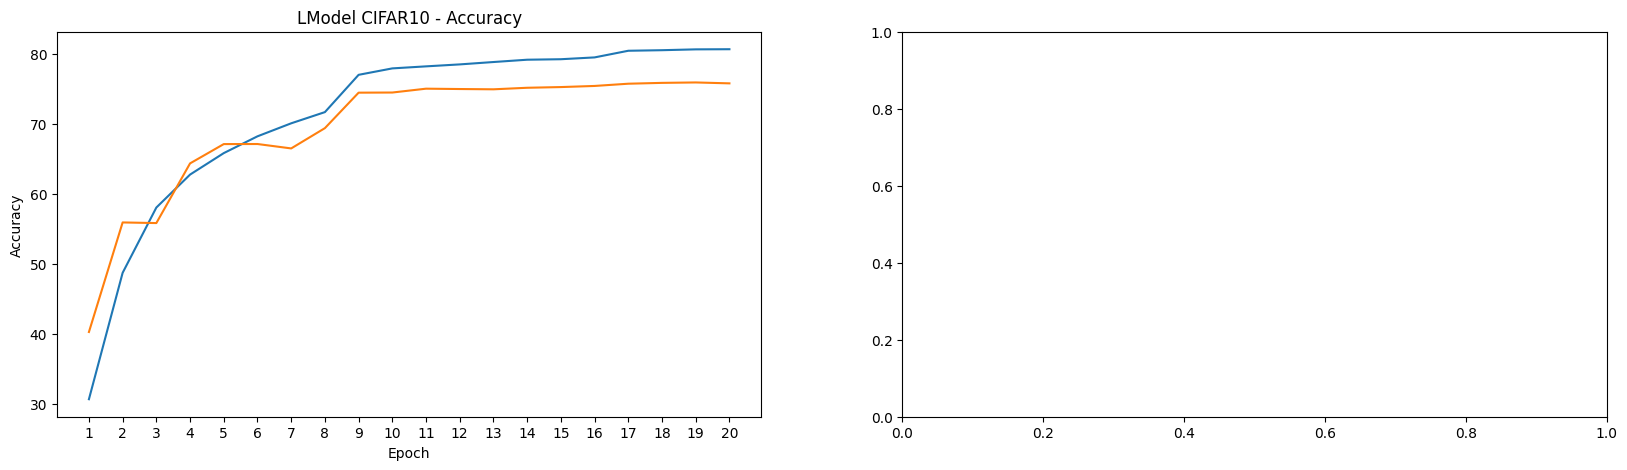

In [ ]:
print("\nPloting Accuracy and Loss history: {}\n".format(model_name))
putils.plot_model_history(model_name,
                   train_acc,test_acc,
                   train_losses,test_losses,
                   save_filename = "model_history")

## Misclassified images


Ploting misclassified images: LModel CIFAR10



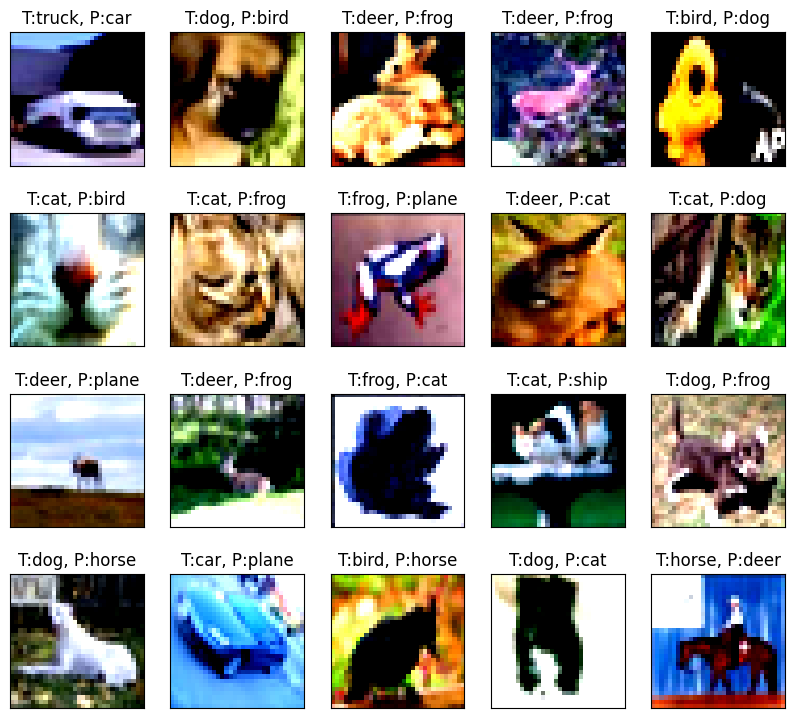

In [ ]:
print ("\nPloting misclassified images: {}\n".format(model_name))

putils.miss_classification('Test',lmodel,
                          device,
                          classes,
                          testloader=test_loader,
                          num_of_images = 20,
                          save_filename="lmodel_misclassified")

# Model with GN from Github

### Model structure

In [ ]:
# from __future__ import print_function
# import torch
# import torchvision
# import torch.nn as nn
# import torch.nn.functional as F
# from torchsummary import summary
# import torch.optim as optim
# from torchvision import datasets, transforms
# from torch.optim.lr_scheduler import StepLR

# import numpy as np
# import matplotlib.pyplot as plt

# import regularization

# multiplier = 2

# class GNet(nn.Module):
#     def __init__(self, dropout_value=0.001):
#         super(GNet, self).__init__()

#         ## CONVOLUTION BLOCK 1
#         self.convblock1 = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=16 * multiplier, kernel_size=(3, 3), stride=1, padding=1),
#             nn.GroupNorm(16 * multiplier, 16 * multiplier),
#             nn.Dropout(dropout_value),
#             nn.ReLU()
#         )

#         self.convblock2 = nn.Sequential(
#             nn.Conv2d(in_channels=16 * multiplier, out_channels=32 * multiplier, kernel_size=(3, 3), padding=1, bias=False),
#             nn.Conv2d(in_channels=32 * multiplier, out_channels=8 * multiplier, kernel_size=(1, 1), padding=0, bias=False),
#             nn.GroupNorm(8 * multiplier, 8 * multiplier),
#             nn.Dropout(dropout_value),
#             nn.ReLU()
#         )

#         self.pool1 = nn.MaxPool2d(2, 2)

#         ## CONVOLUTION BLOCK 2
#         self.convblock3 = nn.Sequential(
#             nn.Conv2d(in_channels=8 * multiplier, out_channels=16 * multiplier, kernel_size=(3, 3), padding=1, dilation=1, bias=False),
#             nn.GroupNorm(16 * multiplier, 16 * multiplier),
#             nn.Dropout(dropout_value),
#             nn.ReLU(),
#         )

#         self.convblock4 = nn.Sequential(
#             nn.Conv2d(in_channels=16 * multiplier, out_channels=32 * multiplier, kernel_size=(3, 3), padding=1, bias=False),
#             nn.Conv2d(in_channels=32 * multiplier, out_channels=8 * multiplier, kernel_size=(1, 1), padding=0, bias=False),
#             nn.GroupNorm(8 * multiplier, 8 * multiplier),
#             nn.Dropout(dropout_value),
#             nn.ReLU(),
#         )

#         self.pool2 = nn.MaxPool2d(2, 2)

#         ## CONVOLUTION BLOCK 3
#         self.convblock5 = nn.Sequential(
#             nn.Conv2d(in_channels=8 * multiplier, out_channels=16 * multiplier, kernel_size=(3, 3), padding=1, dilation=2, bias=False),
#             nn.GroupNorm(16 * multiplier, 16 * multiplier),
#             nn.Dropout(dropout_value),
#             nn.ReLU()
#         )

#         self.convblock6 = nn.Sequential(
#             nn.Conv2d(in_channels=16 * multiplier, out_channels=32 * multiplier, kernel_size=(3, 3), padding=1, dilation=1, bias=False),
#             nn.Conv2d(in_channels=32 * multiplier, out_channels=8 * multiplier, kernel_size=(1, 1), padding=0, bias=False),
#             nn.GroupNorm(8 * multiplier, 8 * multiplier),
#             nn.Dropout(dropout_value),
#             nn.ReLU()
#         )

#         ## CONVOLUTION BLOCK 4
#         self.convblock7 = nn.Sequential(
#             nn.Conv2d(in_channels=8 * multiplier, out_channels=16 * multiplier, kernel_size=(3, 3), padding=1, dilation=1, bias=False),
#             nn.GroupNorm(16 * multiplier, 16 * multiplier),
#             nn.Dropout(dropout_value),
#             nn.ReLU()
#         )

#         self.gap = nn.AvgPool2d(kernel_size=(6, 6))
#         self.fc1 = nn.Linear(16 * multiplier, 10)

#     def forward(self, x):
#         x = self.pool1(self.convblock2(self.convblock1(x)))
#         x = self.pool2(self.convblock4(self.convblock3(x)))
#         x = self.convblock6(self.convblock5(x))
#         x = self.convblock7(x)
#         x = self.gap(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc1(x)

#         return F.log_softmax(x, dim=-1)


In [ ]:
# model = mod.ResNet18()
gmodel = model_gcifar.model_gcifar()

In [ ]:
mutils.model_summary(gmodel, device, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
         GroupNorm-2           [-1, 32, 32, 32]              64
           Dropout-3           [-1, 32, 32, 32]               0
              ReLU-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
            Conv2d-6           [-1, 16, 32, 32]           1,024
         GroupNorm-7           [-1, 16, 32, 32]              32
           Dropout-8           [-1, 16, 32, 32]               0
              ReLU-9           [-1, 16, 32, 32]               0
        MaxPool2d-10           [-1, 16, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           4,608
        GroupNorm-12           [-1, 32, 16, 16]              64
          Dropout-13           [-1, 32, 16, 16]               0
             ReLU-14           [-1, 32,

In [ ]:
# Create CIFAR10 network
# model = model_cifar.Net(dropout_value = 0.05)
# mutils.model_summary(model, device, input_size=(3, 32, 32))

## Build and train model

In [ ]:
test_loader

In [ ]:
# build and train the model
model_name = "GModel CIFAR10"
EPOCHS = 20
lmodel =  lmodel.to(device) # use GPU

# using L1 and L2 regularization
train_acc, train_losses, test_acc, test_losses = mutils.build_model(gmodel,
                                                            device,
                                                            trainloader=train_loader,
                                                            testloader=test_loader,
                                                            epochs=EPOCHS,
                                                            L1_loss_flag=True,
                                                            L2_penalty_val=0.00001,
                                                            lr=0.01)

EPOCH: 0


Loss=2.282763 Batch_id=781 Accuracy=15.10: 100%|██████████| 782/782 [00:56<00:00, 13.95it/s]



Test set: Average loss: 2.097022, Accuracy: 2255/10000 (22.55%)

EPOCH: 1


Loss=1.921349 Batch_id=781 Accuracy=25.13: 100%|██████████| 782/782 [00:55<00:00, 14.12it/s]



Test set: Average loss: 1.797497, Accuracy: 3150/10000 (31.50%)

EPOCH: 2


Loss=1.660017 Batch_id=781 Accuracy=35.05: 100%|██████████| 782/782 [00:54<00:00, 14.46it/s]



Test set: Average loss: 1.541223, Accuracy: 3819/10000 (38.19%)

EPOCH: 3


Loss=1.470213 Batch_id=781 Accuracy=43.47: 100%|██████████| 782/782 [00:52<00:00, 14.99it/s]



Test set: Average loss: 1.433119, Accuracy: 4591/10000 (45.91%)

EPOCH: 4


Loss=1.321377 Batch_id=781 Accuracy=50.69: 100%|██████████| 782/782 [00:55<00:00, 14.10it/s]



Test set: Average loss: 1.254716, Accuracy: 5376/10000 (53.76%)

EPOCH: 5


Loss=1.179785 Batch_id=781 Accuracy=58.53: 100%|██████████| 782/782 [00:53<00:00, 14.57it/s]



Test set: Average loss: 1.158542, Accuracy: 5749/10000 (57.49%)

EPOCH: 6


Loss=1.054224 Batch_id=781 Accuracy=63.86: 100%|██████████| 782/782 [00:54<00:00, 14.28it/s]



Test set: Average loss: 1.041847, Accuracy: 6356/10000 (63.56%)

EPOCH: 7


Loss=0.969245 Batch_id=781 Accuracy=67.17: 100%|██████████| 782/782 [00:50<00:00, 15.60it/s]



Test set: Average loss: 0.965797, Accuracy: 6627/10000 (66.27%)

EPOCH: 8


Loss=0.815627 Batch_id=781 Accuracy=72.81: 100%|██████████| 782/782 [00:54<00:00, 14.30it/s]



Test set: Average loss: 0.856885, Accuracy: 7023/10000 (70.23%)

EPOCH: 9


Loss=0.783798 Batch_id=781 Accuracy=73.91: 100%|██████████| 782/782 [00:52<00:00, 14.78it/s]



Test set: Average loss: 0.851176, Accuracy: 7020/10000 (70.20%)

EPOCH: 10


Loss=0.768008 Batch_id=781 Accuracy=74.54: 100%|██████████| 782/782 [00:51<00:00, 15.16it/s]



Test set: Average loss: 0.852520, Accuracy: 7024/10000 (70.24%)

EPOCH: 11


Loss=0.754415 Batch_id=781 Accuracy=74.82: 100%|██████████| 782/782 [00:51<00:00, 15.33it/s]



Test set: Average loss: 0.843248, Accuracy: 7083/10000 (70.83%)

EPOCH: 12


Loss=0.742555 Batch_id=781 Accuracy=75.52: 100%|██████████| 782/782 [00:56<00:00, 13.94it/s]



Test set: Average loss: 0.831641, Accuracy: 7100/10000 (71.00%)

EPOCH: 13


Loss=0.731762 Batch_id=781 Accuracy=75.87: 100%|██████████| 782/782 [00:53<00:00, 14.63it/s]



Test set: Average loss: 0.830158, Accuracy: 7085/10000 (70.85%)

EPOCH: 14


Loss=0.721059 Batch_id=781 Accuracy=76.20: 100%|██████████| 782/782 [00:55<00:00, 14.03it/s]



Test set: Average loss: 0.831717, Accuracy: 7094/10000 (70.94%)

EPOCH: 15


Loss=0.711808 Batch_id=781 Accuracy=76.62: 100%|██████████| 782/782 [00:50<00:00, 15.56it/s]



Test set: Average loss: 0.819408, Accuracy: 7119/10000 (71.19%)

EPOCH: 16


Loss=0.684750 Batch_id=781 Accuracy=77.60: 100%|██████████| 782/782 [00:53<00:00, 14.51it/s]



Test set: Average loss: 0.814327, Accuracy: 7178/10000 (71.78%)

EPOCH: 17


Loss=0.681380 Batch_id=781 Accuracy=77.69: 100%|██████████| 782/782 [00:57<00:00, 13.57it/s]



Test set: Average loss: 0.813519, Accuracy: 7177/10000 (71.77%)

EPOCH: 18


Loss=0.679705 Batch_id=781 Accuracy=77.82: 100%|██████████| 782/782 [00:55<00:00, 13.97it/s]



Test set: Average loss: 0.813311, Accuracy: 7198/10000 (71.98%)

EPOCH: 19


Loss=0.678063 Batch_id=781 Accuracy=77.86: 100%|██████████| 782/782 [00:53<00:00, 14.55it/s]



Test set: Average loss: 0.813854, Accuracy: 7171/10000 (71.71%)



## Test Accuracy

In [ ]:
mutils.get_test_accuracy(gmodel, device, test_loader)


Accuracy of the network on the 10000 test images: 71.71%



### Class level Accuracy

In [ ]:
mutils.class_based_accuracy(gmodel, device, classes, test_loader)

Accuracy of plane : 78 %
Accuracy of   car : 87 %
Accuracy of  bird : 60 %
Accuracy of   cat : 43 %
Accuracy of  deer : 72 %
Accuracy of   dog : 63 %
Accuracy of  frog : 82 %
Accuracy of horse : 89 %
Accuracy of  ship : 86 %
Accuracy of truck : 88 %


## Visualization


Ploting Accuracy and Loss history: GModel CIFAR10



TypeError: ignored

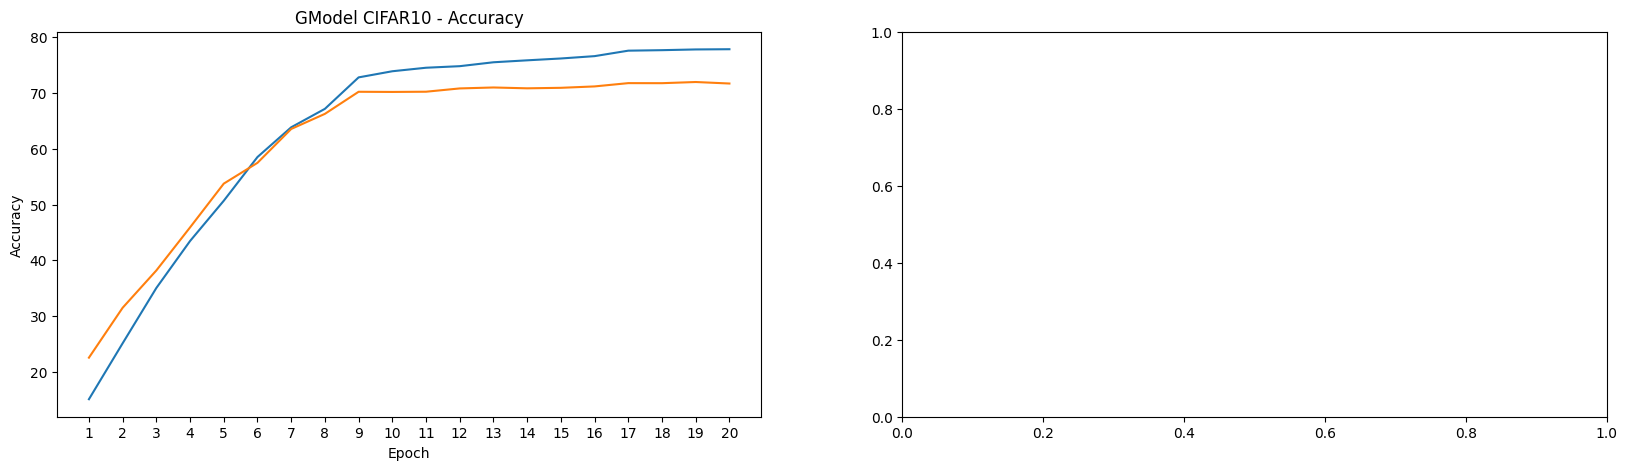

In [ ]:
print("\nPloting Accuracy and Loss history: {}\n".format(model_name))
putils.plot_model_history(model_name,
                   train_acc,test_acc,
                   train_losses,test_losses,
                   save_filename = "model_history")

## Misclassified images


Ploting misclassified images: GModel CIFAR10



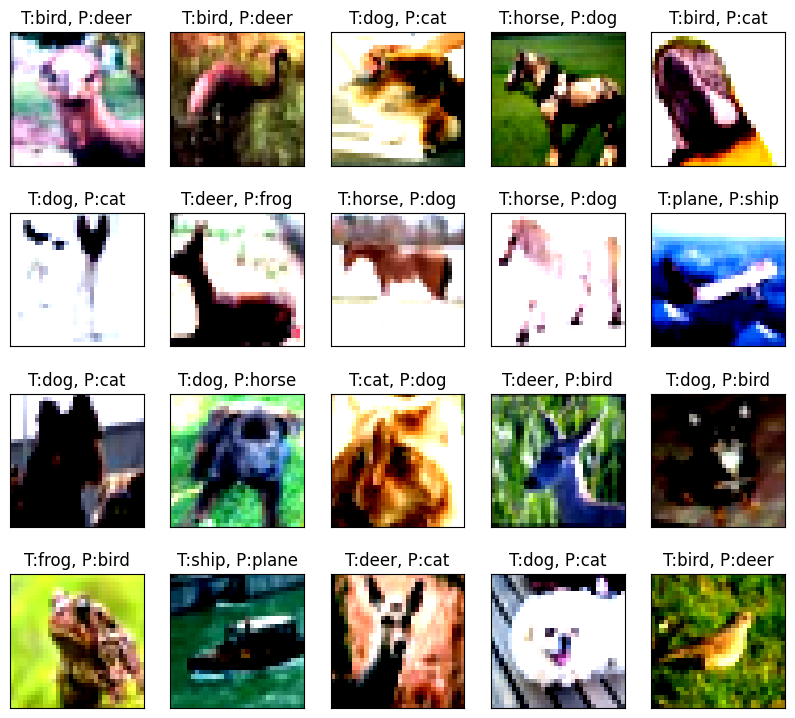

In [ ]:
print ("\nPloting misclassified images: {}\n".format(model_name))

putils.miss_classification('Test',gmodel,
                          device,
                          classes,
                          testloader=test_loader,
                          num_of_images = 20,
                          save_filename="lmodel_misclassified")